In [1]:
# 載入需要的套件
import os
import sys

import backtrader as bt
import pandas as pd
import pyfolio as pf

# 取得當前檔案的所在目錄
# current_dir = os.path.dirname(os.path.abspath(__name__))
# parent_dir1 = os.path.dirname(os.path.join(current_dir, ".."))

current_notebook_dir = os.getcwd()
project_root_path = os.path.dirname(os.path.dirname(current_notebook_dir))
sys.path.append(project_root_path)

import Chapter1.utils as chap1_utils

/opt/homebrew/Caskroom/miniforge/base/envs/stock/lib/python3.13/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
chap1_utils.finlab_login()

輸入成功!


In [3]:
analysis_period_start_date = "2017-05-16"
analysis_period_end_date = "2021-05-15"

In [4]:
top_N_stocks = chap1_utils.get_top_stocks_by_market_value(
    excluded_industry=[
        "金融業",
        "金融保險業",
        "存託憑證",
        "建材營造",
    ],
    pre_list_date="2017-01-03"
)

Your version is 1.5.0, please install a newer version.
Use "pip install finlab==1.5.3" to update the latest version.


Due to your status as a free user, the most recent data has been shortened or limited.
Daily usage: 0.9 / 500 MB - company_basic_info


In [7]:
# 取得指定股票代碼列表在給定日期範圍內的每日 OHLCV 數據。
all_stock_data = chap1_utils.get_daily_OHLCV_data(
    stock_symbols=top_N_stocks,
    start_date=analysis_period_start_date,
    end_date=analysis_period_end_date,
)
all_stock_data["datetime"] = all_stock_data["datetime"].astype(str)
all_stock_data["asset"] = all_stock_data["asset"].astype(str)

/Users/houguanyu/Documents/code/python/stock/Quant/PythonQuantrading/Chapter1/utils.py:476: FutureWarning: YF.download() has changed argument auto_adjust default to True
  pd.DataFrame(yf.download(symbol, start=start_date, end=end_date)).droplevel(
[*********************100%***********************]  1 of 1 completed
/Users/houguanyu/Documents/code/python/stock/Quant/PythonQuantrading/Chapter1/utils.py:476: FutureWarning: YF.download() has changed argument auto_adjust default to True
  pd.DataFrame(yf.download(symbol, start=start_date, end=end_date)).droplevel(
[*********************100%***********************]  1 of 1 completed
/Users/houguanyu/Documents/code/python/stock/Quant/PythonQuantrading/Chapter1/utils.py:476: FutureWarning: YF.download() has changed argument auto_adjust default to True
  pd.DataFrame(yf.download(symbol, start=start_date, end=end_date)).droplevel(
[*********************100%***********************]  1 of 1 completed
/Users/houguanyu/Documents/code/python/stock/Q

In [8]:
# 指定各個季度下的因子組合和權重，用於排序和計算加權平均
select_rank_factor_dict = {
    f"{year}-Q{quarter}": [
        {"name": "營運現金流", "weight": 0.2},
        {"name": "歸屬母公司淨利", "weight": 0.2},
        {"name": "營業利益成長率", "weight": 0.2},
        {"name": "稅前淨利成長率", "weight": 0.2},
        {"name": "稅後淨利成長率", "weight": 0.2},
    ]
    for year in range(2017, 2021)
    for quarter in range(1, 5)
}
select_rank_factor_dict

{'2017-Q1': [{'name': '營運現金流', 'weight': 0.2},
  {'name': '歸屬母公司淨利', 'weight': 0.2},
  {'name': '營業利益成長率', 'weight': 0.2},
  {'name': '稅前淨利成長率', 'weight': 0.2},
  {'name': '稅後淨利成長率', 'weight': 0.2}],
 '2017-Q2': [{'name': '營運現金流', 'weight': 0.2},
  {'name': '歸屬母公司淨利', 'weight': 0.2},
  {'name': '營業利益成長率', 'weight': 0.2},
  {'name': '稅前淨利成長率', 'weight': 0.2},
  {'name': '稅後淨利成長率', 'weight': 0.2}],
 '2017-Q3': [{'name': '營運現金流', 'weight': 0.2},
  {'name': '歸屬母公司淨利', 'weight': 0.2},
  {'name': '營業利益成長率', 'weight': 0.2},
  {'name': '稅前淨利成長率', 'weight': 0.2},
  {'name': '稅後淨利成長率', 'weight': 0.2}],
 '2017-Q4': [{'name': '營運現金流', 'weight': 0.2},
  {'name': '歸屬母公司淨利', 'weight': 0.2},
  {'name': '營業利益成長率', 'weight': 0.2},
  {'name': '稅前淨利成長率', 'weight': 0.2},
  {'name': '稅後淨利成長率', 'weight': 0.2}],
 '2018-Q1': [{'name': '營運現金流', 'weight': 0.2},
  {'name': '歸屬母公司淨利', 'weight': 0.2},
  {'name': '營業利益成長率', 'weight': 0.2},
  {'name': '稅前淨利成長率', 'weight': 0.2},
  {'name': '稅後淨利成長率', 'weight': 0.2}],


In [9]:
# 列出所有會使用到的因子名稱
all_factors = []
for quarter, factor_pair in select_rank_factor_dict.items():
    for factor in factor_pair:
        all_factors.append(factor["name"])
all_factors = list(set(all_factors))
all_factors

['營業利益成長率', '歸屬母公司淨利', '稅後淨利成長率', '營運現金流', '稅前淨利成長率']

In [ ]:
# 取得所有會使用到的因子數據
rank_factors_data_dict = {}
trading_days = pd.date_range(
    start=analysis_period_start_date, end=analysis_period_end_date
)
for factor in all_factors:
    # 取得因子數據，並按照股票代碼和日期進行排序與填充
    quarter_factor_data = (
        chap1_utils.get_factor_data(
            stock_symbols=top_N_stocks,
            factor_name=factor,
            trading_days=list(trading_days), # type: ignore
        ).reset_index()
        .assign(factor_name=factor)
        .sort_values(by=["asset", "datetime"])
        .groupby("asset", group_keys=False)
        .apply(lambda group: group.ffill())
        .dropna()
    )
    # 根據因子值進行股票排序
    quarter_factor_data = chap1_utils.rank_stocks_by_factor(
        factor_df=quarter_factor_data,
        positive_corr=True,
        rank_column="value",
        rank_result_column="rank",
    ).drop(columns=["value"])
    rank_factors_data_dict[factor] = quarter_factor_data

# 先用 get_factor_data 拿到 for loop 指定因子的因子資料 -> quarter_factor_data
# 然後透過 rank_stocks_by_factor 做排序，更新 quarter_factor_data
# 最後將 因子名稱當作 key, quarter_factor_data 當作 value 儲存到 rank_factors_data_dict

Daily usage: 1.4 / 500 MB - fundamental_features:營業利益成長率
Daily usage: 3.9 / 500 MB - etl:financial_statements_deadline
Daily usage: 30.4 / 500 MB - price:收盤價


/var/folders/jd/cst_1lwd4vdgv06j7c62ffp00000gn/T/ipykernel_94112/3303427087.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.ffill())


Daily usage: 31.7 / 500 MB - fundamental_features:歸屬母公司淨利


/var/folders/jd/cst_1lwd4vdgv06j7c62ffp00000gn/T/ipykernel_94112/3303427087.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.ffill())


Daily usage: 33.1 / 500 MB - fundamental_features:稅後淨利成長率


/var/folders/jd/cst_1lwd4vdgv06j7c62ffp00000gn/T/ipykernel_94112/3303427087.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.ffill())


Daily usage: 34.4 / 500 MB - fundamental_features:營運現金流


/var/folders/jd/cst_1lwd4vdgv06j7c62ffp00000gn/T/ipykernel_94112/3303427087.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.ffill())


Daily usage: 35.9 / 500 MB - fundamental_features:稅前淨利成長率


/var/folders/jd/cst_1lwd4vdgv06j7c62ffp00000gn/T/ipykernel_94112/3303427087.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.ffill())


In [27]:
rank_factors_data_dict["歸屬母公司淨利"]

,datetime,asset,factor_name,rank
0,2017-05-16,1101,歸屬母公司淨利,708.0
1,2017-05-17,1101,歸屬母公司淨利,708.0
2,2017-05-18,1101,歸屬母公司淨利,708.0
3,2017-05-19,1101,歸屬母公司淨利,708.0
4,2017-05-20,1101,歸屬母公司淨利,708.0
...,...,...,...,...
1105972,2021-05-11,9958,歸屬母公司淨利,236.0
1105973,2021-05-12,9958,歸屬母公司淨利,236.0
1105974,2021-05-13,9958,歸屬母公司淨利,236.0
1105975,2021-05-14,9958,歸屬母公司淨利,236.0


In [29]:
min(rank_factors_data_dict["歸屬母公司淨利"]["rank"])

1.0

In [13]:
print(quarter_factor_data)

          datetime asset factor_name   rank
0       2017-05-16  1101     稅前淨利成長率  736.0
1       2017-05-17  1101     稅前淨利成長率  736.0
2       2017-05-18  1101     稅前淨利成長率  736.0
3       2017-05-19  1101     稅前淨利成長率  736.0
4       2017-05-20  1101     稅前淨利成長率  736.0
...            ...   ...         ...    ...
1105972 2021-05-11  9958     稅前淨利成長率  559.0
1105973 2021-05-12  9958     稅前淨利成長率  559.0
1105974 2021-05-13  9958     稅前淨利成長率  559.0
1105975 2021-05-14  9958     稅前淨利成長率  559.0
1105976 2021-05-15  9958     稅前淨利成長率  559.0

[1105977 rows x 4 columns]


In [31]:
quarter_factor_data

,datetime,asset,factor_name,rank
0,2017-05-16,1101,稅前淨利成長率,736.0
1,2017-05-17,1101,稅前淨利成長率,736.0
2,2017-05-18,1101,稅前淨利成長率,736.0
3,2017-05-19,1101,稅前淨利成長率,736.0
4,2017-05-20,1101,稅前淨利成長率,736.0
...,...,...,...,...
1105972,2021-05-11,9958,稅前淨利成長率,559.0
1105973,2021-05-12,9958,稅前淨利成長率,559.0
1105974,2021-05-13,9958,稅前淨利成長率,559.0
1105975,2021-05-14,9958,稅前淨利成長率,559.0


In [36]:
# 計算每個季度的加權排名
all_factor_data = pd.DataFrame()
for quarter, factor_pair in select_rank_factor_dict.items():
    start_date, end_date = chap1_utils.convert_quarter_to_dates(quarter)
    trading_days = (
        pd.date_range(start=start_date, end=end_date).strftime("%Y-%m-%d").tolist()
    )

    # 取得當季因子的名稱與權重
    pairs = [x["name"] for x in factor_pair]
    weights = [x["weight"] for x in factor_pair]

    # 計算每個季度的加權排名
    quarter_factor_data = chap1_utils.calculate_weighted_rank(
        ranked_dfs=[
            rank_factors_data_dict[pairs[0]][
                (rank_factors_data_dict[pairs[0]]["datetime"] <= end_date) 
                & (rank_factors_data_dict[pairs[0]]["datetime"] >= start_date)
            ],
            rank_factors_data_dict[pairs[1]][
                (rank_factors_data_dict[pairs[1]]["datetime"] <= end_date)
                & (rank_factors_data_dict[pairs[1]]["datetime"] >= start_date)
            ],
            rank_factors_data_dict[pairs[2]][
                (rank_factors_data_dict[pairs[2]]["datetime"] <= end_date)
                & (rank_factors_data_dict[pairs[2]]["datetime"] >= start_date)
            ],
            rank_factors_data_dict[pairs[3]][
                (rank_factors_data_dict[pairs[3]]["datetime"] <= end_date)
                & (rank_factors_data_dict[pairs[3]]["datetime"] >= start_date)
            ],
            rank_factors_data_dict[pairs[4]][
                (rank_factors_data_dict[pairs[4]]["datetime"] <= end_date)
                & (rank_factors_data_dict[pairs[4]]["datetime"] >= start_date)
            ],
        ],
        weights=weights, # 使用每個因子的權重
        positive_corr=True, # 因子與未來收益正相關
        rank_column="rank",
    )
    # 合併該季度的因子數據
    all_factor_data = pd.concat([all_factor_data, quarter_factor_data])

# 重設索引並將日期與股票代碼轉換為字串格式
all_factor_data = all_factor_data.reset_index(drop=True)
all_factor_data["datetime"] = all_factor_data["datetime"].astype(str)
all_factor_data["asset"] = all_factor_data["asset"].astype(str)
all_factor_data["weighted_rank"] = all_factor_data["weighted_rank"].astype(float)

/Users/houguanyu/Documents/code/python/stock/Quant/PythonQuantrading/Chapter1/utils.py:392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"rank_{i}"] = df[rank_column] * weights[i]
/Users/houguanyu/Documents/code/python/stock/Quant/PythonQuantrading/Chapter1/utils.py:392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"rank_{i}"] = df[rank_column] * weights[i]
/Users/houguanyu/Documents/code/python/stock/Quant/PythonQuantrading/Chapter1/utils.py:392: SettingWithCopyWarning: 
A value is trying to be s

In [37]:
all_factor_data

,datetime,asset,weighted_rank
0,2017-05-16,1101,751.0
1,2017-05-16,1102,402.5
2,2017-05-16,1103,549.5
3,2017-05-16,1104,441.0
4,2017-05-16,1108,120.0
...,...,...,...
1101589,2021-05-15,9943,563.0
1101590,2021-05-15,9944,558.0
1101591,2021-05-15,9945,561.0
1101592,2021-05-15,9955,554.0


In [38]:
# 將因子數據與股票數據進行合併
all_stock_and_factor_data = pd.merge(
    all_stock_data, all_factor_data, on=["datetime", "asset"], how="outer"
).dropna()
# 按股票代碼和日期排序，並填補缺失值
all_stock_and_factor_data = (
    all_stock_and_factor_data.sort_values(by=["asset", "datetime"])
    .groupby("asset", group_keys=False)
    .apply(lambda group: group.ffill())
    .rename(columns={"weighted_rank": "rank"})
    .reset_index(drop=True)
)

/var/folders/jd/cst_1lwd4vdgv06j7c62ffp00000gn/T/ipykernel_94112/803168338.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.ffill())


In [39]:
all_stock_and_factor_data

,Open,High,Low,Close,Volume,datetime,asset,rank
0,17.247242,17.395926,17.197681,17.395926,12148541.0,2017-05-16,1101,751.0
1,17.296805,17.321586,17.172902,17.247244,6210221.0,2017-05-17,1101,751.0
2,17.123339,17.247242,17.024217,17.222462,2288047.0,2017-05-18,1101,751.0
3,17.148120,17.172900,17.098558,17.098558,2978676.0,2017-05-19,1101,751.0
4,17.272021,17.272021,17.048996,17.148119,2313878.0,2017-05-22,1101,751.0
...,...,...,...,...,...,...,...,...
733505,106.380010,114.042976,106.380010,110.436874,20742937.0,2021-05-10,9958,443.0
733506,109.535364,113.141466,100.069345,104.576973,16102417.0,2021-05-11,9958,443.0
733507,104.576965,105.478491,94.209421,95.110947,13411871.0,2021-05-12,9958,443.0
733508,91.504842,98.266283,88.349502,95.561707,7893400.0,2021-05-13,9958,443.0


In [40]:
# 定義回測資料格式，新增排名資料
class PandasDataWithRank(bt.feeds.PandasData):
    params = {
        ("datetime", "datetime"), # 日期欄位
        ("open", "Open"), # 開盤價欄位
        ("high", "High"), # 最高價欄位
        ("low", "Low"), # 最低價欄位
        ("close", "Close"), # 收盤價欄位
        ("volume", "Volume"), # 成交量欄位
        ("rank", "Rank"), # 排名欄位
        ("openinterest", -1), # 持倉量欄位（不使用）
    }
    # 新增因子排名這條數據線
    lines = ("rank",)

In [43]:
# 定義策略：根據因子排名買入和賣出股票
class FactorRankStragety(bt.Strategy):
    # 策略參數：要買入和賣出的股票數量，及每檔股票的交易金額
    params = (
        ("buy_n", None), # 需要買入的股票數量
        ("sell_n", None), # 需要賣出的股票數量
        ("each_cash", None), # 每檔股票交易的金額
    )

    def __init__(self):
        self.stocks = self.datas # 將所有股票數據儲存在 self.stocks 變數中
        self.buy_positions = set() # 紀錄已買入的股票名稱
        self.sell_positions = set() # 紀錄已賣出的股票名稱

    def next(self):
        # 取得當天所有股票的因子排名： ex: {stock1: 1, stock2: 2}
        ranks = {data._name: data.rank[0] for data in self.stocks}
        # 根據排名從低到高排序: 排名越小的因子值越小, 排名越大的因子值越大
        sorted_ranks = sorted(ranks.items(), key=lambda x:x[1])

        # 取得排名最高的 buy_n 個股票（要買入的股票）
        if self.params.buy_n:
            buy_n_list = sorted_ranks[-self.params.buy_n:]
            buy_n_names = [name for name, rank in buy_n_list] # 提取股票名稱

        # 取得排名最低的 sell_n 個股票（要賣出的股票）
        if self.params.sell_n:
            sell_n_list = sorted_ranks[:self.params.sell_n]
            sell_n_names = [name for name, rank in sell_n_list]

        # 進行買入與賣出操作
        for data in self.stocks:
            # 取得當前股票名稱
            name = data._name
            # 取得當前股票的收盤價
            close_price = data.close[0]
            # 計算每檔股票的交易股數
            size = int(self.params.each_cash / close_price)
            # 1. 處理賣出（做空）操作
            if self.params.sell_n:
                if name in self.sell_positions and name not in sell_n_names:
                    # 如果股票已經賣出且不再賣出清單，則平倉
                    self.close(data)
                    self.sell_positions.remove(name)
                elif name not in self.sell_positions and name in sell_n_names:
                    # 如果股票在賣出清單中，則賣出
                    self.sell(data, size=size)
                    self.sell_positions.add(name)
            # 2. 處理買入（做多）操作
            if self.params.buy_n:
                if name in self.buy_positions and name not in buy_n_names:
                    # 如果股票已買入且不在買入清單，則平倉
                    self.close(data)
                    self.buy_positions.remove(name)
                elif name not in self.buy_positions and name in buy_n_names:
                    self.buy(data, size=size)
                    self.buy_positions.add(name)



In [45]:
# 設定回測引擎
cerebro = bt.Cerebro()
# 加入交易策略 FactorRankStrategy，設定策略參數：
# buy_n: 每次要買入的股票數量（20檔）
# sell_n: 每次要賣出的股票數量（20檔）
# each_cash: 每檔股票的交易金額，這裡是總資金的90%除以40檔股票，確保每檔股票有足夠資金配置
cerebro.addstrategy(
    FactorRankStragety, buy_n=20, sell_n=20, each_cash=2000_000 * 0.9 / 40
)
# 依序加入每檔股票的數據到回測引擎中
stock_list = list(set(all_stock_and_factor_data["asset"]))
for stock in stock_list:
    data = all_stock_and_factor_data[all_stock_and_factor_data["asset"] == stock]
    data = data.drop(columns=["asset"]) # 移除不必要欄位
    data["datetime"] = pd.to_datetime(data["datetime"]) # 日期欄位轉為 datetime 格式
    data = data.dropna().sort_values(by=["datetime"]).reset_index(drop=True)
    data = PandasDataWithRank(dataname=data) # 使用自訂的數據格式 PandasDataWithRank
    cerebro.adddata(data, name=stock) # 加入數據到回測引擎
# 設定初始資金為 2000 萬元
cerebro.broker.set_cash(2000_000)
# 設定每筆交易的手續費為 0.1%
cerebro.broker.setcommission(commission=0.001)
# 加入 PyFolio 分析器，用於生成投資組合的性能分析報告
cerebro.addanalyzer(bt.analyzers.PyFolio)
# 運行策略
results = cerebro.run()



/opt/homebrew/Caskroom/miniforge/base/envs/stock/lib/python3.13/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.073%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2017-05-16
End date,2021-05-14
Total months,46
,Backtest
Annual return,4.073%
Cumulative returns,16.684%
Annual volatility,8.357%
Sharpe ratio,0.52
Calmar ratio,0.26
Stability,0.30
Max drawdown,-15.961%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.96,2020-01-20,2020-09-24,2021-05-10,341
1,7.87,2018-05-29,2018-11-23,2019-07-11,293
2,3.57,2021-05-11,2021-05-14,NaT,NaN
3,3.54,2017-11-20,2018-04-11,2018-05-10,124
4,2.83,2017-05-16,2017-06-23,2017-07-17,45


/opt/homebrew/Caskroom/miniforge/base/envs/stock/lib/python3.13/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/opt/homebrew/Caskroom/miniforge/base/envs/stock/lib/python3.13/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
New Normal,0.03%,-1.43%,1.58%
Covid,-0.00%,-3.29%,2.62%


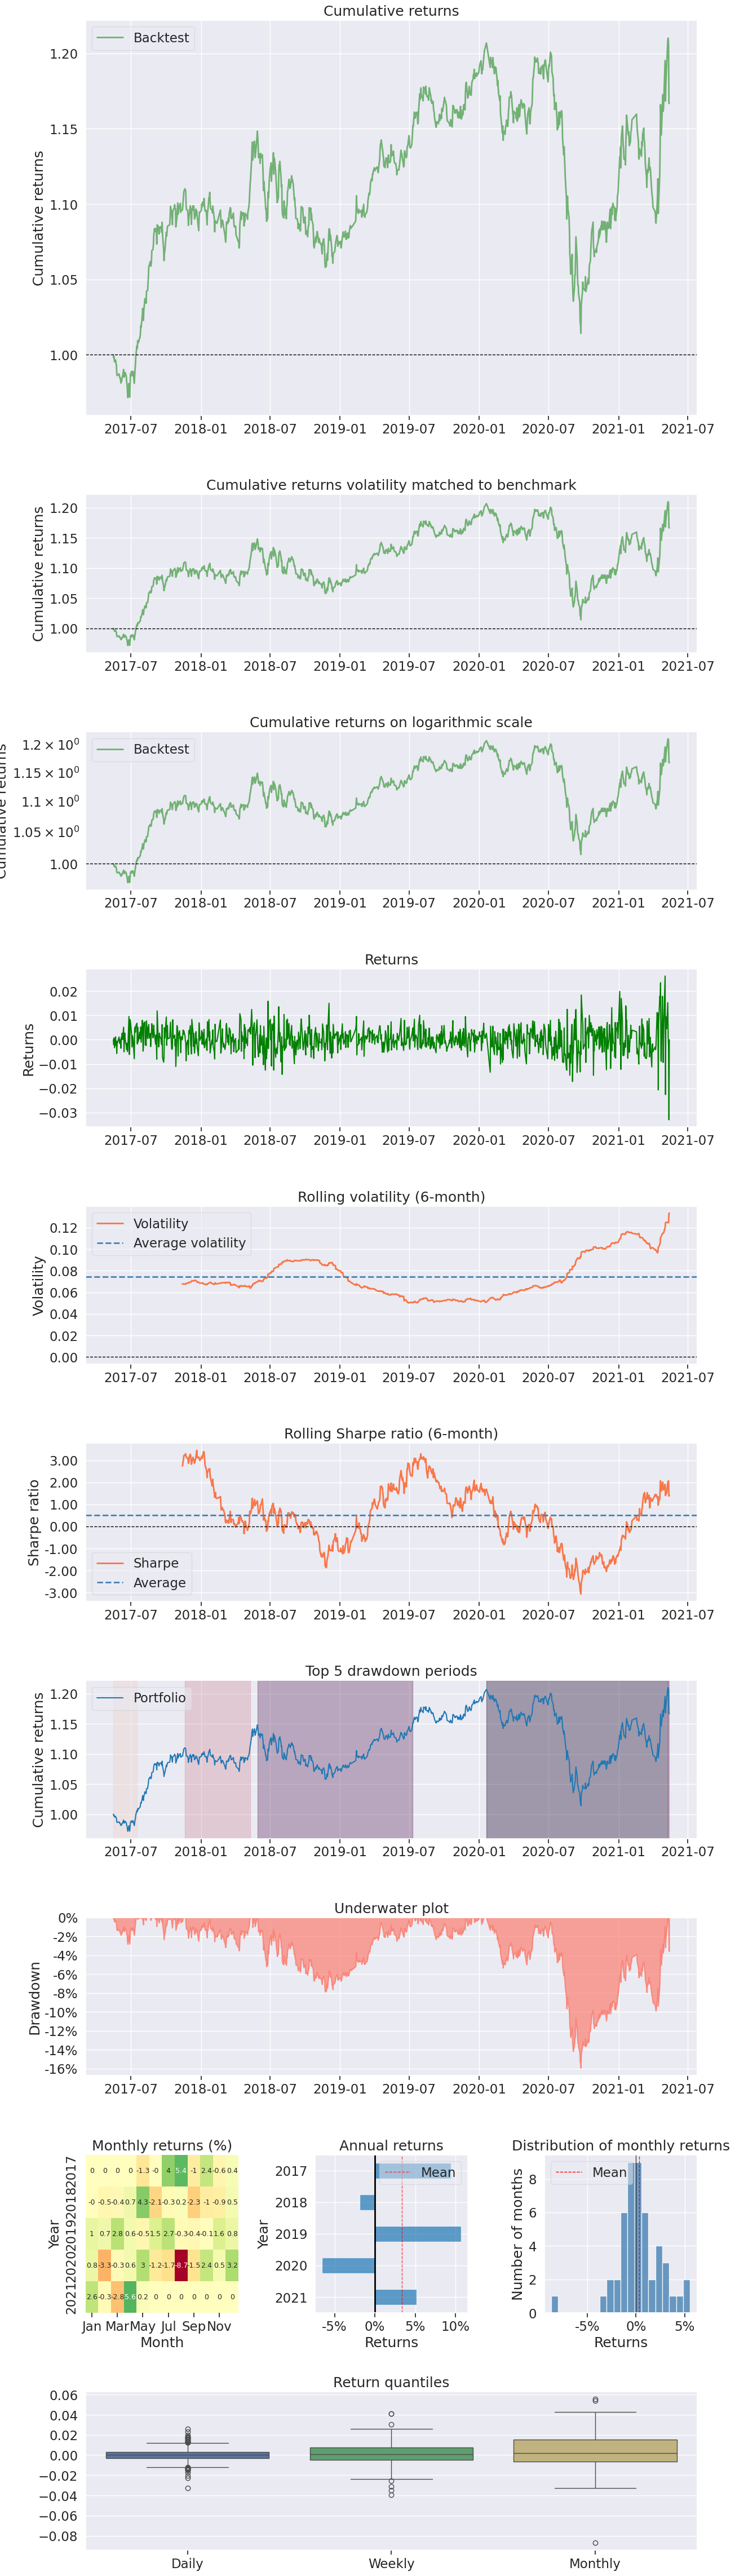

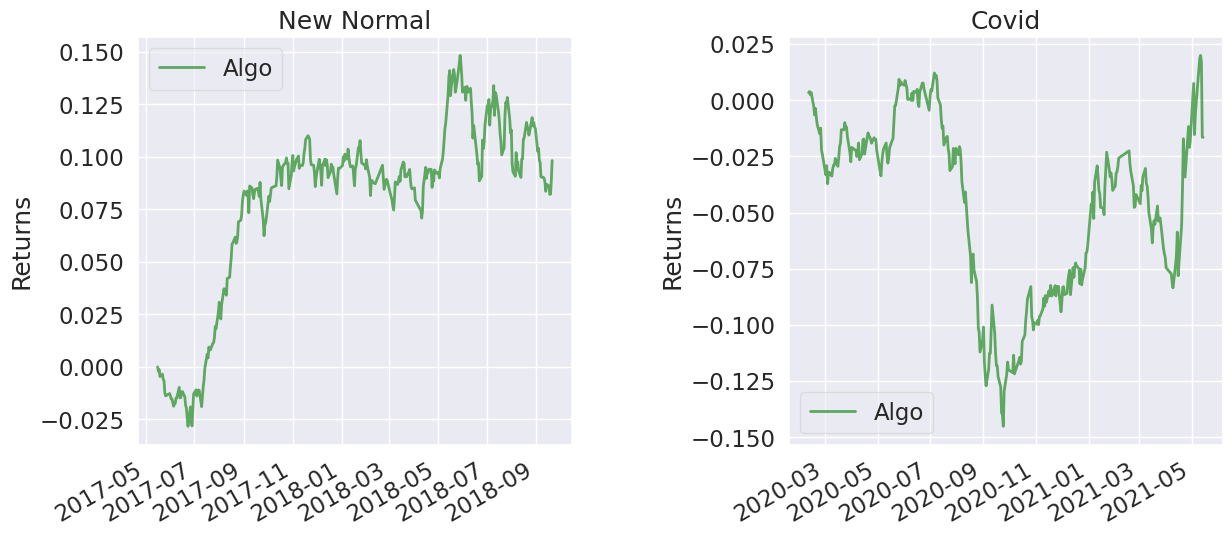

In [46]:
# 取得策略結果並生成投資組合分析報告
start = results[0] # 取得回測結果中的第一個策略
pyfoliozer = start.analyzers.getbyname("pyfolio")
(
    returns, 
    positions,
    transactions,
    gross_lev,
) = pyfoliozer.get_pf_items()
# 使用PyFolio 生成完整的投資組合表現分析報告
pf.create_full_tear_sheet(returns)